In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report, log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

In [3]:
def check(y):
    assert set(y) == {-1,1}
    return y

In [4]:
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  stumps= None, stump_weights= None, roll = 0,
                  clf= None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None):

    y = check(y) # Kì vọng nhãn bằng ±1

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
        
    else:
        sizes = np.ones(shape=X.shape[0]) * 100
    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')
    
    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Nếu tất cả các điểm dự đoán thuộc lớp positive, sẽ tô màu đỏ cho background
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)
        
    if roll:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = predict(np.c_[xx.ravel(), yy.ravel()], stumps, stump_weights)
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

In [5]:
def truncate_adaboost(stumps, stump_weights, t: int):
    assert t > 0, 't must be a positive integer'
    x = stumps[:t]
    y = stump_weights[:t]
    return x, y

In [6]:
def plot_staged_adaboost(X, y, stumps, sample_weights, stump_weights, start=0, end=10):
    # larger grid
    fig, axes = plt.subplots(figsize=(8, (end-start)*3),
                             nrows=(end-start),
                             ncols=2,
                             sharex=True,
                             dpi=100)
    
    fig.set_facecolor('white')
    for i in range(start, end):
        ax1, ax2 = axes[i-start]

        # Plot weak learner
        ehe = ax1.set_title(f'Weak learner at t={i + 1}')
        plot_adaboost(X, y, clf= stumps[i],
                      sample_weights= sample_weights[i],
                      annotate=False, ax=ax1)

        # Plot strong learner
        new_stumps,  new_sw = truncate_adaboost(stumps, stump_weights, t=i + 1)
        ehe = ax2.set_title(f'Strong learner at t={i + 1}')
        plot_adaboost(X, y, new_stumps, new_sw, sample_weights= sample_weights[i], roll=1, annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

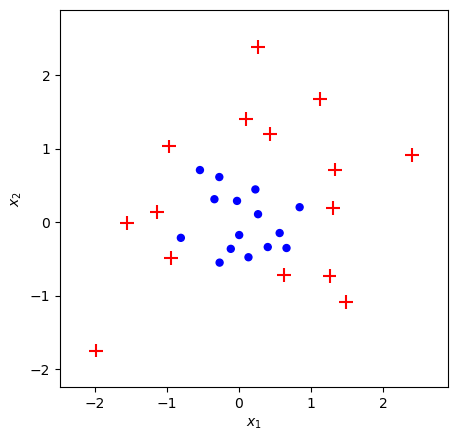

In [7]:
def make_dataset(n: int = 100, random_seed: int = None):
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

X, y = make_dataset(n=30, random_seed=10)
plot_adaboost(X, y)

In [8]:
X.shape, y.shape

((30, 2), (30,))

Train error: 0.0%


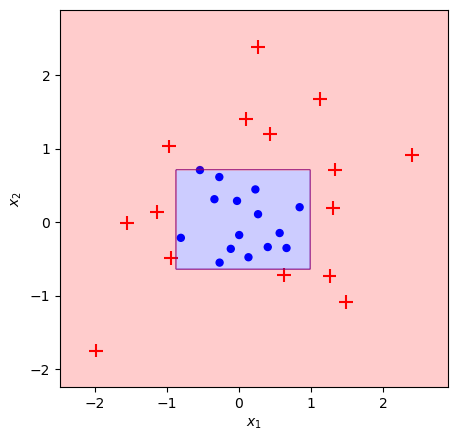

In [9]:
bench = AdaBoostClassifier(n_estimators=15, algorithm='SAMME').fit(X, y)
plot_adaboost(X, y, clf= bench)

train_err = (bench.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

In [10]:
y.shape

(30,)

In [11]:
def init_model(iters, X):
    n = X.shape[0]
    
    sample_weights = np.zeros((iters, n))
    stumps = np.zeros(iters, dtype= object)
    stump_weights = np.zeros(iters)
    errors = np.zeros(iters)
    return stumps, stump_weights, sample_weights, errors

In [12]:
def AdaBoostClf(X, y, iters= 10):
    n = X.shape[0]
    
    # Check y
    y = check(y)
    # Initialize
    stumps, stump_weights, sample_weights, errors = init_model(iters= iters, X= X)
    
    # First weight = 1/n
    sample_weights[0] = np.ones(shape= n) / n
    
    for i in range(iters):
        
        # Fit for stump: weak learner
        current_sew = sample_weights[i]
        stump = DecisionTreeClassifier(max_depth= 1, max_leaf_nodes= 2)
        stump = stump.fit(X, y, sample_weight= current_sew)
        
        # Calculate error
        stump_pred = stump.predict(X)
        error = current_sew[stump_pred != y].sum()
        stump_weight = np.log((1 - error) / error) / 2
        
        # New sample weight
        new_sew = current_sew * np.exp(-1 * stump_weight * y * stump_pred)
        
        # Renormalize weights
        new_sew = new_sew / new_sew.sum()
        
        # If not last iter, update sample weights for i+1
        if (i + 1) < iters:
            sample_weights[i+1] = new_sew
            
        # Save result
        errors[i] = error
        stumps[i] = stump
        stump_weights[i] = stump_weight
        
    return stumps, stump_weights, sample_weights

In [13]:
def predict(X, stumps, stump_weights):
    stump_preds = np.array([stump.predict(X) for stump in stumps])
    return np.sign(np.dot(stump_weights, stump_preds))

In [14]:
stumps, stump_weights, sample_weights = AdaBoostClf(X, y, iters= 15)
pred = predict(X, stumps, stump_weights)

In [15]:
# Show metrics
print("Accuracy score: %f" % accuracy_score(y, pred))
print("Confusion Matrix:")
print(confusion_matrix(y, pred))
print(classification_report(y, pred))
print('Log loss:', log_loss(y, pred)/len(y))

Accuracy score: 1.000000
Confusion Matrix:
[[15  0]
 [ 0 15]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Log loss: 3.330669073875471e-17


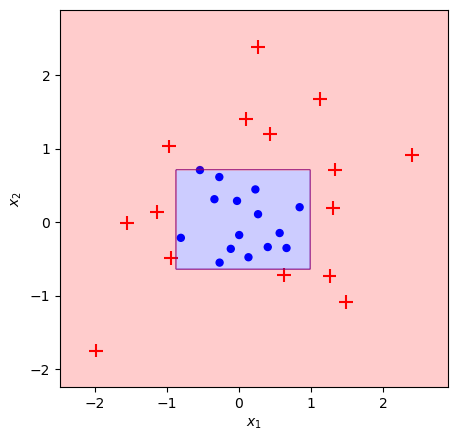

In [16]:
plot_adaboost(X, y, stumps, stump_weights, roll= 1)

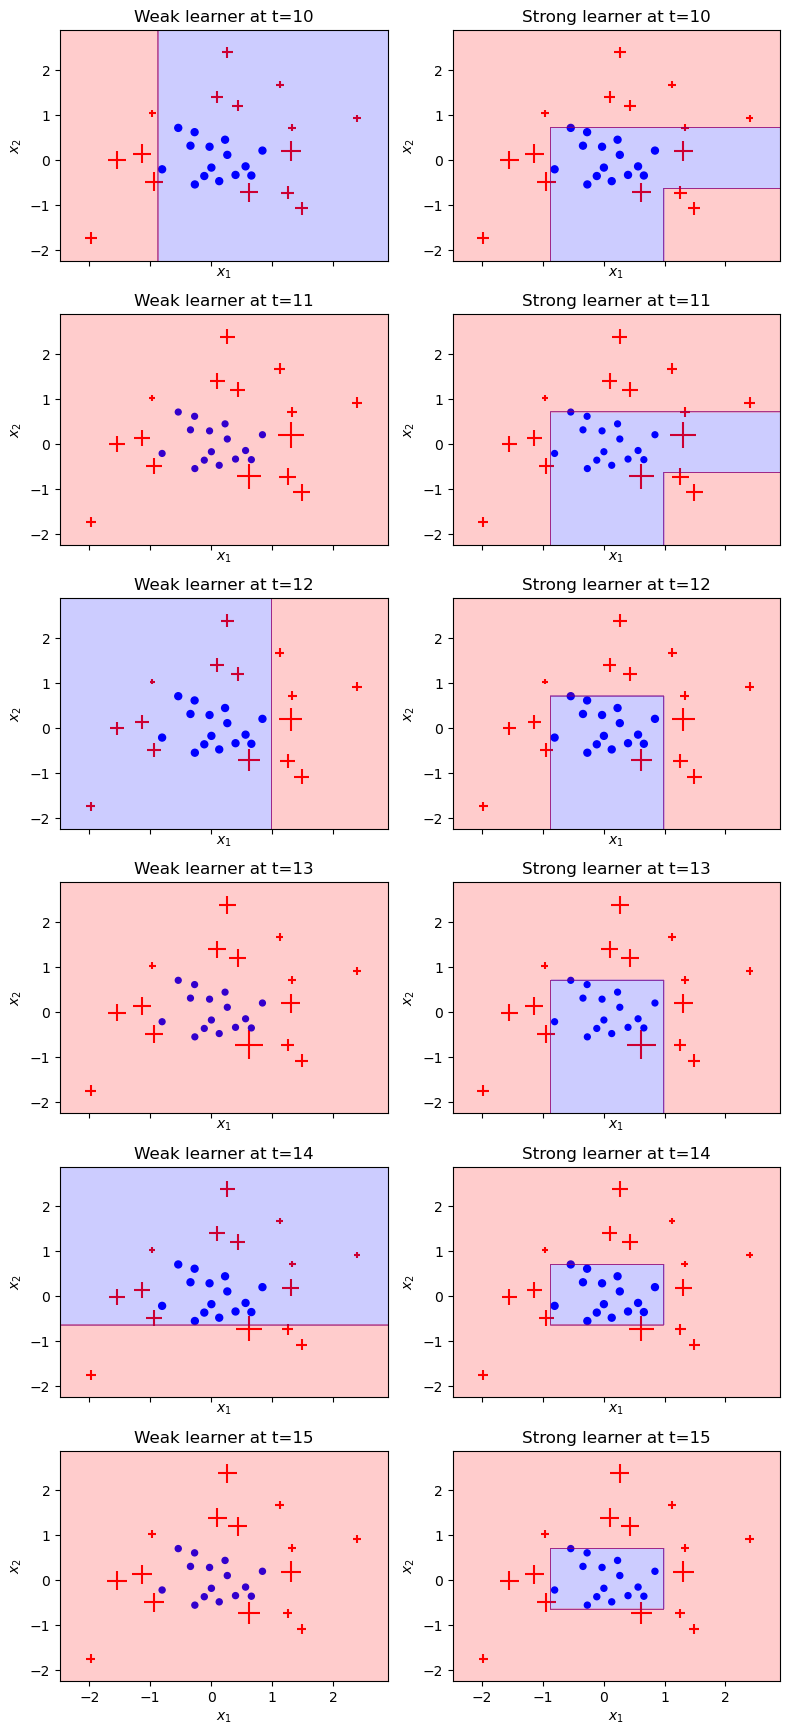

In [17]:
plot_staged_adaboost(X, y, stumps, sample_weights, stump_weights, start=9, end=15)

In [13]:
titanic = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/titanic.csv')

# Data manipulation
titanic.fillna(titanic['Age'].mean(), inplace=True)
titanic.replace({'Sex':{'male':0, 'female':1}}, inplace=True)
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic.drop(columns=['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,FamilySize
0,0,3,0,22.0,2
1,1,1,1,38.0,2
2,1,3,1,26.0,1
3,1,1,1,35.0,2
4,0,3,0,35.0,1


In [14]:
from sklearn.model_selection import train_test_split

Xt = titanic[['Pclass', 'Sex', 'Age', 'FamilySize']].values
yt = titanic[['Survived']].values
yt[yt == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=102)

print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (712, 4) (712, 1)
Test set: (179, 4) (179, 1)


In [22]:
clc = AdaBoostClassifier(n_estimators=10, algorithm='SAMME').fit(X_train, y_train.reshape(-1))

test_err = (clc.predict(X_train) != y_train).mean()
print(f'Test error: {test_err:.1%}')

Test error: 46.5%


In [20]:
stumps1, stump_weights1, sample_weights1 = AdaBoostClf(X= X_train, y= y_train.reshape(-1), iters= 10)
predt = predict(X_test, stumps1, stump_weights1)

In [21]:
# Show metrics
print("Accuracy score: %f" % accuracy_score(y_test, predt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predt))
print(classification_report(y_test, predt))
print('Log loss:', log_loss(y_test, predt)/len(y_test))

Accuracy score: 0.843575
Confusion Matrix:
[[102  12]
 [ 16  49]]
              precision    recall  f1-score   support

          -1       0.86      0.89      0.88       114
           1       0.80      0.75      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

Log loss: 0.0301830571526064


In [15]:
adu = titanic[['Age', 'Sex']].values
ytt = titanic[['Survived']].values
ytt[ytt == 0] = -1

x_train, x_test, Y_train, Y_test = train_test_split(adu, ytt, test_size=0.2, random_state=102)

print('Training set:', x_train.shape, Y_train.shape)
print('Test set:', x_test.shape, Y_test.shape)

Training set: (712, 2) (712, 1)
Test set: (179, 2) (179, 1)


In [22]:
X, x_train

(array([[ 0.22863013,  0.44513761],
        [ 0.26607016,  2.38496733],
        [ 0.40020999, -0.33763234],
        [-1.97772828, -1.7433723 ],
        [ 0.1327083 , -0.47614201],
        [ 0.66023155, -0.35087189],
        [-0.33914025,  0.31216994],
        [ 0.56515267, -0.14742026],
        [ 0.84222474,  0.2035808 ],
        [-0.02590534,  0.2890942 ],
        [-0.80459114, -0.21269764],
        [-0.96506567,  1.02827408],
        [-0.26731719, -0.54930901],
        [ 1.25647226, -0.7319695 ],
        [ 0.00429143, -0.17460021],
        [ 0.26551159,  0.10854853],
        [-0.27124799,  0.61320418],
        [ 1.484537  , -1.07980489],
        [-1.54540029, -0.00838385],
        [ 1.12369125,  1.67262221],
        [-1.13660221,  0.13513688],
        [ 1.3315865 ,  0.71527897],
        [ 0.62133597, -0.72008556],
        [ 1.30847308,  0.19501328],
        [-0.53987907,  0.70816002],
        [ 2.39470366,  0.91745894],
        [ 0.43302619,  1.20303737],
        [ 0.09914922,  1.397

(435,)


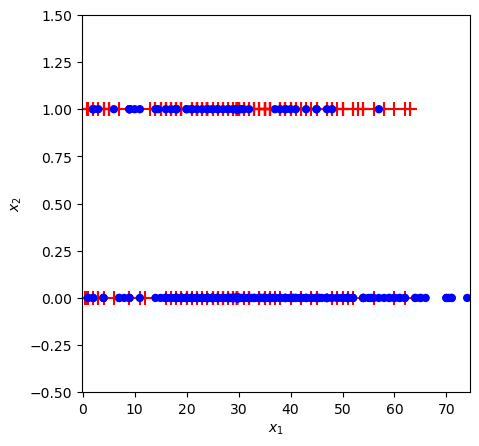

In [20]:
plot_adaboost(x_train, Y_train.reshape(-1))

In [16]:
stumps2, stump_weights2, sample_weights2 = AdaBoostClf(X= X_train, y= Y_train.reshape(-1), iters= 100)
predtt = predict(x_test, stumps2, stump_weights2)

NameError: name 'AdaBoostClf' is not defined

In [59]:
# Show metrics
print("Accuracy score: %f" % accuracy_score(Y_test, predtt))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predtt))
print(classification_report(Y_test, predtt))
print('Log loss:', log_loss(Y_test, predtt)/len(Y_test))

Accuracy score: 0.821229
Confusion Matrix:
[[101  13]
 [ 19  46]]
              precision    recall  f1-score   support

          -1       0.84      0.89      0.86       114
           1       0.78      0.71      0.74        65

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179

Log loss: 0.03449490463480336


TypeError: multiple values for argument 's'

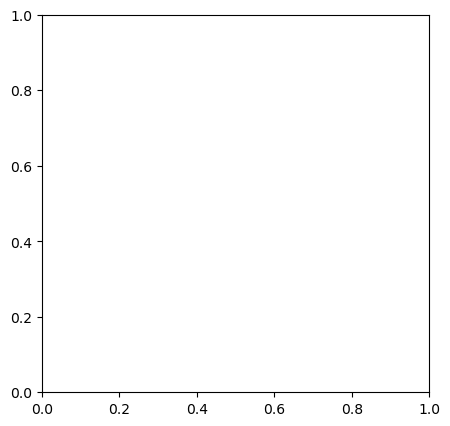

In [60]:
plot_adaboost(X_test, Y_test.reshape(-1), stumps2, stump_weights2, roll= 1)